# Module 03

## Session 08 Ensemble Methods

* Data: adult.csv
    - target: income
    - feature: preprocess
        - missing value: simple imputer with constant
        - one hot encoding: relationship, race, sex
        - binary encoding: workclass, martial status, occupation, native country
        - ordinal encoding: education (already encoded)
        - no treatment: numerical
        - out: fnlwgt
* Random state 10 
* data splitting 70:30
* stratify
* model:
    - tree: model tree(max depth 3) and compute precsiion, recall, f1 test set then compute the feature importances and show the tree
    - adaboost: tree adaptive boosting (max depth 3, n_estimator(B) 200, learning rate 0.1) and compute precsiion, recall, f1 test set then compute the feature importances
    - gbc: gradient boosting (max depth 3, n_estimator(B) 200, learning rate 0.1) and compute precsiion, recall, f1 test set then compute the feature importances
    - xgb: extreme gradient boosting (max depth 3, n_estimator(B) 200, learning rate 0.1) and compute precsiion, recall, f1 test set then compute the feature importances
    - model selection using grid search (tree, tree adaboost, gbc, xgb) optimized by f1 and using stratified CV 5 fold
    - hyperparameter tuning the winner (optimize B, L, and max depth) ptimized by f1 and using stratified CV 5 fold
    - Evaluate the tuned model in test set using precision, recall, f1 score, ROC, PRC. Compare the result

# Library

In [68]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, plot_roc_curve, plot_precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Data

In [69]:
df_adult = pd.read_csv('./datasets/adult.csv')
df_adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [70]:
df_adult.replace("?", np.nan, inplace=True)

In [71]:
df_adult.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

# Preprocessing scenario

In [72]:
onehot = OneHotEncoder()
onehot_var = ['relationship', 'race', 'gender']

binary = ce.BinaryEncoder()
imputer = SimpleImputer(strategy='constant', fill_value='NC')
binary_pipe = Pipeline(
    [
        ('imputer', imputer),
        ('encoder', binary)
    ]
)
binary_var = ['workclass', 'marital-status', 'occupation', 'native-country']

transformer = ColumnTransformer(
    [
        ('onehot', onehot, onehot_var),
        ('binary', binary_pipe, binary_var),
    ],
    remainder='passthrough'
)

# Data Splitting

In [73]:
X = df_adult.drop(columns=['fnlwgt', 'income', 'education'])
y = np.where(df_adult['income'] == '>50K',1,0)

In [74]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.3,
    random_state=10
)

# Data transformation

In [75]:
X_trainval_prep = transformer.fit_transform(X_trainval)
X_test_prep = transformer.fit_transform(X_test)

/opt/homebrew/Caskroom/miniforge/base/envs/boost/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/homebrew/Caskroom/miniforge/base/envs/boost/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [76]:
X_trainval_prep = pd.DataFrame(X_trainval_prep)
X_test_prep = pd.DataFrame(X_test_prep)


In [77]:
onehot_features = list(transformer.transformers_[0][1].get_feature_names())
binary_features = list(transformer.transformers_[1][1]['encoder'].get_feature_names())
features = onehot_features + binary_features + ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [78]:
len(features)

39

In [79]:
X_trainval_prep.columns = features
X_test_prep.columns = features

# Modeling

## Modeling result function

In [80]:
def modeling_result(models):
    models.fit(X_trainval_prep, y_trainval)

    y_pred = models.predict(X_test_prep)
    print(classification_report(y_test, y_pred))

    fi = models.feature_importances_

    imp_table = pd.DataFrame(
        {
            'imp':fi
        },
        index=features
    )

    imp_table.sort_values(by='imp').plot(kind='barh', figsize=(12,12))

## 1. TREE

In [81]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_trainval_prep, y_trainval)

DecisionTreeClassifier(max_depth=3)

In [82]:
y_pred = tree.predict(X_test_prep)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     11147
           1       0.77      0.48      0.59      3506

    accuracy                           0.84     14653
   macro avg       0.81      0.72      0.75     14653
weighted avg       0.83      0.84      0.83     14653



              precision    recall  f1-score   support

           0       0.85      0.96      0.90     11147
           1       0.77      0.48      0.59      3506

    accuracy                           0.84     14653
   macro avg       0.81      0.72      0.75     14653
weighted avg       0.83      0.84      0.83     14653



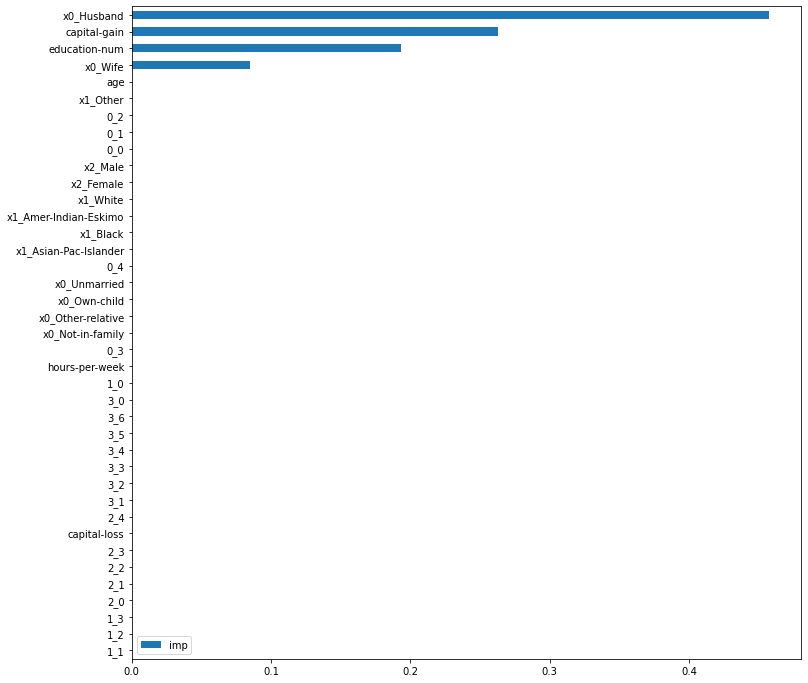

In [83]:
modeling_result(tree)

## 2. Adaptive Boosting 

In [84]:
tree = DecisionTreeClassifier(max_depth=3)
tree_ada = AdaBoostClassifier(
    tree,
    n_estimators=200,
    learning_rate=0.1,
    random_state=10
)

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     11147
           1       0.79      0.60      0.69      3506

    accuracy                           0.87     14653
   macro avg       0.84      0.78      0.80     14653
weighted avg       0.86      0.87      0.86     14653



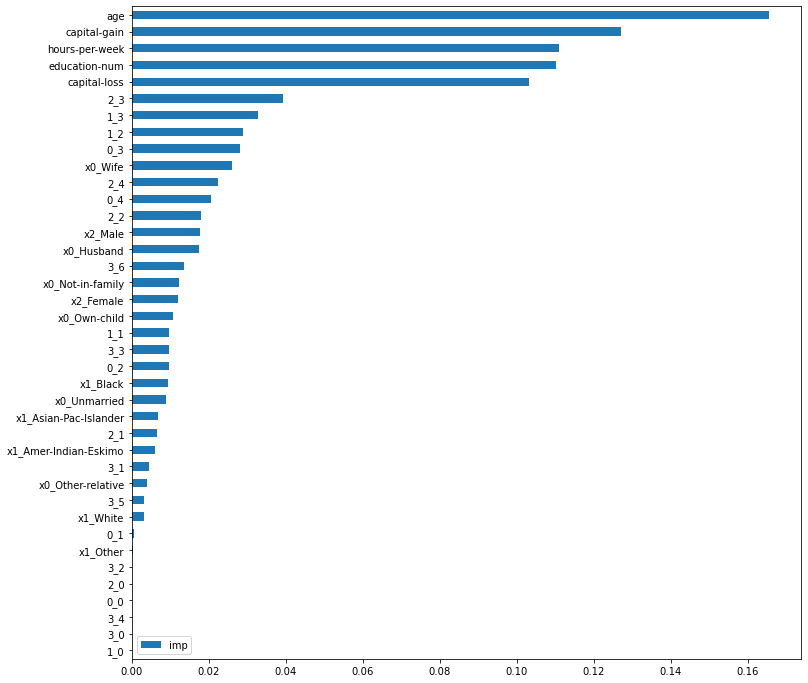

In [85]:
modeling_result(tree_ada)

## 3. Gradient Boosting

In [86]:
model_gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10
)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     11147
           1       0.78      0.60      0.68      3506

    accuracy                           0.86     14653
   macro avg       0.83      0.77      0.80     14653
weighted avg       0.86      0.86      0.86     14653



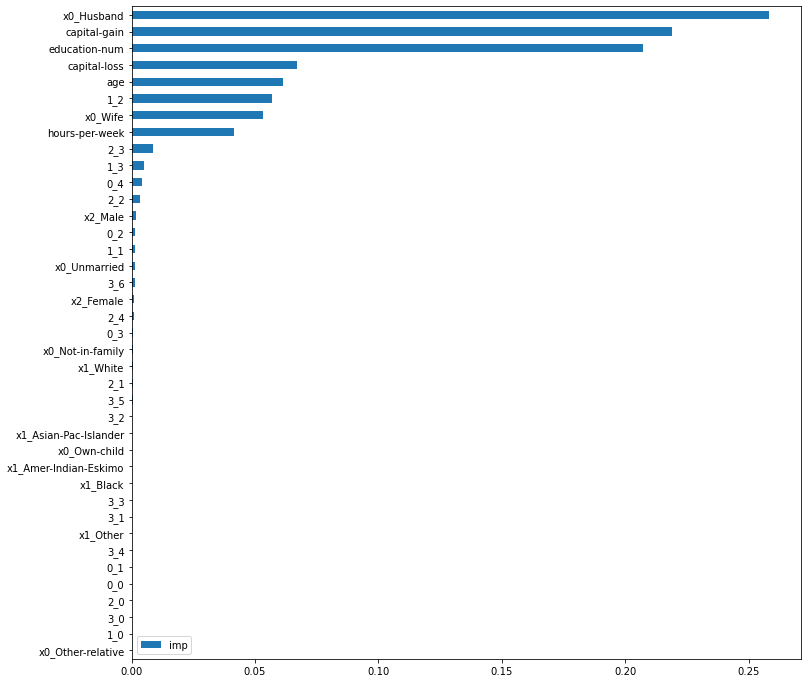

In [87]:
modeling_result(model_gbc)

## 4. XGB

In [88]:
model_xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    random_state=10
)

In [89]:
modeling_result(model_xgb)